In [79]:
class Config():
    IMAGE_HEIGHT = 256
    IMAGE_WIDTH = 256
    BATCH_SIZE = 4
    LATENT_DIM = 256
    DEVICE = "cpu"
    NUM_CLASSES = 12
    TEST_SPLIT = 0.2
    EPOCHS = 5
    
cfg = Config()

In [80]:

from PIL import Image
import numpy as np
from tqdm import tqdm
import os
from glob import glob

import torch
from torch import nn
from torch.utils import data
import torchvision
import torch.nn.functional as F
from  torch.nn.utils import spectral_norm
from torchvision import models
import torchvision.transforms as transforms


In [175]:
class GauGanDataset:
    def __init__(self,img_paths):
        self.img_paths = img_paths
        self.img_transforms = transforms.Compose([
            transforms.Resize((cfg.IMAGE_HEIGHT,cfg.IMAGE_WIDTH)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.map_transforms = transforms.Compose([
            transforms.Resize((cfg.IMAGE_HEIGHT,cfg.IMAGE_WIDTH)),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self,index):
        image = Image.open(self.img_paths[index]).convert("RGB")
        label = Image.open(self.img_paths[index].replace("jpg","bmp"))
        label_img = Image.open(self.img_paths[index].replace("jpg","png")).convert("RGB")
        image = self.img_transforms(image)
        label = self.map_transforms(label).long().squeeze(0)
        label_img = self.img_transforms(label_img)
        label_ohe = F.one_hot(label,num_classes=cfg.NUM_CLASSES).permute(2,0,1).to(image.dtype)
        return {
            "image":image,
            "segmentation_map":label_ohe,
            "label_img": label_img

        }
        

In [176]:
class EncoderBlock(nn.Module):
    def __init__(self,channels_in,channels_out,with_norm=True):
        super(EncoderBlock,self).__init__()
        if with_norm:
            self.block = nn.Sequential(
                                        nn.Conv2d(in_channels=channels_in,out_channels=channels_out,\
                                                    kernel_size=3,stride=2,bias=False,padding=1),           
                                        nn.InstanceNorm2d(channels_out),
                                        nn.LeakyReLU()
                                        )
        else:
            self.block = nn.Sequential(
                                        nn.Conv2d(in_channels=channels_in,out_channels=channels_out,\
                                                    kernel_size=3,stride=2,bias=False,padding=1),
                                        nn.LeakyReLU()
                                        )
    def forward(self,x):
        return self.block(x)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.block1 = EncoderBlock(3,64,with_norm=False)
        self.block2 = EncoderBlock(64,128)
        self.block3 = EncoderBlock(128,256)
        self.block4 = EncoderBlock(256,512)
        self.block5 = EncoderBlock(512,512)
        self.block6 = EncoderBlock(512,512)
        # self.block7 = EncoderBlock(512,512)
        self.flattening_block = nn.Conv2d(512,8192,kernel_size=1,padding=0)

        self.linear_mu_branch = nn.Linear(in_features=8192,out_features=cfg.LATENT_DIM)
        self.linear_var_branch = nn.Linear(in_features=8192,out_features=cfg.LATENT_DIM)
        

    def forward(self,x):
        x = self.block1(x)
        # print(x.shape)
        x = self.block2(x)
        # print(x.shape)
        x = self.block3(x)
        # print(x.shape)
        x = self.block4(x)
        # print(x.shape)
        x = self.block5(x)
        # print(x.shape)
        x = self.block6(x)
        # print(x.shape)
        # x = self.block7(x)
        # print(x.shape)
        x = x.reshape(x.shape[0],x.shape[1]*x.shape[2]*x.shape[3])
        # print(x.shape)
        
        
        mu = self.linear_mu_branch(x)
        var = self.linear_var_branch(x)
        
        # print(mu.shape,var.shape)
        return mu,var
        # return x
    def get_latent_vector(self,mu,var):
        epsilon = torch.randn(mu.size(),device=cfg.DEVICE)
        latent_vec = mu  + torch.exp((var*0.5)) * epsilon  
        return latent_vec

In [177]:
class SPADE(nn.Module):
    def __init__(self,num_channels):
        super(SPADE, self).__init__()
        self.bn = nn.BatchNorm2d(num_channels,affine=False)
        self.conv_1 = nn.Sequential(spectral_norm(nn.Conv2d(num_channels,128,kernel_size=3,padding=1)),\
                                   nn.ReLU())
        self.conv_1_1  = spectral_norm(nn.Conv2d(128, num_channels, kernel_size=3, padding=1))
        self.conv_2 = spectral_norm(nn.Conv2d(128,  num_channels, kernel_size=3, padding=1))
        
    def forward(self,x,segmentation_map):
        # print(x.shape)
        # BN
        x = self.bn(x)
        # Resize Map
        segmentation_map = F.interpolate(segmentation_map, size=x.size()[2:], mode='nearest')
        # Calc gamma and beta 
        output_shared = self.conv_1(x)
        gamma = self.conv_1_1(output_shared)
        beta = self.conv_2(output_shared)
        # rescale
        # print(x.shape,gamma.shape,beta.shape)
        out = x*(1+gamma) + beta
        return out
class SPADEResBlk(nn.Module):
    def __init__(self,num_features_in,num_features_out):
        super(SPADEResBlk,self,).__init__()
        self.spade1 = SPADE(num_channels=num_features_in)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels=num_features_in,\
            out_channels=num_features_out,kernel_size=3,padding=1))
        self.spade2 = SPADE(num_channels=num_features_out)
        self.conv2 = spectral_norm(nn.Conv2d(in_channels=num_features_out,\
            out_channels=num_features_out,kernel_size=3,padding=1))
        self.skip_connection_spade = SPADE(num_channels=num_features_in)
        self.skip_connection_conv = spectral_norm(nn.Conv2d(in_channels=num_features_in,\
                                                out_channels=num_features_out,\
                                                    kernel_size=1,\
                                                        bias=False))
    
    def forward(self,x,segmentation_map):
        skip_features = self.skip_connection_spade(x,segmentation_map)
        skip_features = F.leaky_relu(skip_features)
        skip_features = self.skip_connection_conv(skip_features)

        x = self.conv1(F.leaky_relu(self.spade1(x,segmentation_map)))
        x = self.conv2(F.leaky_relu(self.spade2(x,segmentation_map)))
        return skip_features + x   
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.linear1 = nn.Linear(cfg.LATENT_DIM,16384)
        self.upsample = nn.Upsample(scale_factor=2)
        self.block1 = SPADEResBlk(num_features_in=1024,num_features_out=1024)
        self.block2 = SPADEResBlk(num_features_in=1024,num_features_out=1024)
        self.block3 = SPADEResBlk(num_features_in=1024,num_features_out=512)
        self.block4 = SPADEResBlk(num_features_in=512,num_features_out=256)
        self.block5 = SPADEResBlk(num_features_in=256,num_features_out=128)
        self.block6 = SPADEResBlk(num_features_in=128,num_features_out=64)
        # self.block7 = SPADEResBlk(num_features_in=64,num_features_out=32)

        self.conv = nn.Conv2d(in_channels=64,out_channels=3,kernel_size=3,padding=1)

    def forward(self,latent_vec,segmentation_map):
        x = self.linear1(latent_vec)
        x = x.reshape(-1,1024,4,4)
        x = self.block1(x,segmentation_map)
        x = self.upsample(x)
        x = self.block2(x,segmentation_map)
        x = self.upsample(x)
        x = self.block3(x,segmentation_map)
        x = self.upsample(x)
        x = self.block4(x,segmentation_map)
        x = self.upsample(x)
        x = self.block5(x,segmentation_map)
        x = self.upsample(x)
        x = self.block6(x,segmentation_map)
        x = self.upsample(x)
        # print(x.shape)        
        # x = self.block7(x,segmentation_map)
        # x = self.upsample(x)
        # print(x.shape)        
        x = F.leaky_relu(x)
        x = self.conv(x)
        x = torch.tanh(x)
        return x
# gen = Generator().to("cpu")
# segmentation_map = torch.randn(4,12,256,256).to("cpu")
# lvec = torch.randn(4,256).to("cpu")
# op = gen(lvec,segmentation_map)
# op.shape,segmentation_map.shape,lvec.shape                     

In [178]:
class DiscriminatorBlock(nn.Module):
    def __init__(self,channels_in,channels_out,with_norm=True):
        super(DiscriminatorBlock,self).__init__()
        if with_norm:
            self.block = nn.Sequential(
                                        spectral_norm(nn.Conv2d(in_channels=channels_in,out_channels=channels_out,\
                                                    kernel_size=4,stride=2,bias=False,padding=1)),           
                                        nn.InstanceNorm2d(channels_out),
                                        nn.LeakyReLU()
                                        )
        else:
            self.block = nn.Sequential(
                                        spectral_norm(nn.Conv2d(in_channels=channels_in,out_channels=channels_out,\
                                                    kernel_size=4,stride=2,bias=False,padding=1)),
                                        nn.LeakyReLU()
                                        )
    def forward(self,x):
        return self.block(x)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        # change input channeldim        
        self.block1 = spectral_norm(nn.Conv2d(cfg.NUM_CLASSES+3,64,kernel_size=4,stride=2,bias=True))
        self.block2 = DiscriminatorBlock(64,128,False)
        self.block3 = DiscriminatorBlock(128,256)
        self.block4 = DiscriminatorBlock(256,512)
        self.block5 = DiscriminatorBlock(512,512)
        self.in7 = nn.InstanceNorm2d(512)
        self.conv8 = spectral_norm(nn.Conv2d(512,1,kernel_size=4))
    
    def forward(self,segmentation_map,img):
        concat_img = torch.concat([segmentation_map,img],dim=1)
        op1 = self.block2(self.block1(concat_img))
        op2 = self.block3(op1)
        op3 = self.block4(op2)
        op4 = self.block5(op3)
        op5 = self.conv8(F.leaky_relu(self.in7(op4)))
        return [op1,op2,op3,op4,op5]


In [179]:
# gen loss = g_loss + kl_loss + vgg_loss + feature_loss
# g loss between - loss between descriminator prediction, and actual label
# kl_loss : encoder output mean,variance
# vgg_loss: loss between generated image (by generator) and actual image
# feature_loss: loss between real desc output and fake desc output
class Gen_loss(nn.Module):
    def __init__(self):
        super(Gen_loss,self).__init__()
        self.criterion = F.binary_cross_entropy_with_logits
    def forward(self,pred,target):
        return self.criterion(pred,target)
class KLD_Loss(nn.Module):
    def __init__(self):
        super(KLD_Loss,self).__init__()
    def forward(self,mu,logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss,self).__init__()
        vgg = models.vgg19(pretrained=True).to(cfg.DEVICE).features
        for param in vgg.parameters():
            param.requires_grad = False
        self.f1 = nn.Sequential(*[vgg[x] for x in range(2)])
        self.f2 = nn.Sequential(*[vgg[x] for x in range(7)])
        self.f3 = nn.Sequential(*[vgg[x] for x in range(12)])
        self.f4 = nn.Sequential(*[vgg[x] for x in range(21)])
        self.f5 = nn.Sequential(*[vgg[x] for x in range(30)])
    def forward(self,x,y):
        loss=0
        x1 = self.f1(x)
        y1 = self.f1(y)
        loss1 = F.l1_loss(x1,y1)

        x2 = self.f2(x)
        y2 = self.f2(y)
        loss2 = F.l1_loss(x2,y2)

        x3 = self.f3(x)
        y3 = self.f3(y)
        loss3 = F.l1_loss(x3,y3)

        x4 = self.f4(x)
        y4 = self.f4(y)
        loss4 = F.l1_loss(x4,y4)

        x5 = self.f5(x)
        y5 = self.f5(y)
        loss5 = F.l1_loss(x5,y5)

        loss += loss1/32 + loss2/16 + loss3/8 + loss4/4 + loss5
        return loss
class FeatureLossDisc(nn.Module):
    def __init__(self):
        super(FeatureLossDisc,self).__init__()
    def forward(self,real_disc_outputs,fake_disc_outputs):
        loss=0
        for real_disc_output,fake_disc_output in zip(real_disc_outputs,fake_disc_outputs):
            loss+= F.l1_loss(real_disc_output,fake_disc_output)
        return loss/len(real_disc_outputs)

In [180]:
class Disc_HingeLoss(nn.Module):
    def __init__(self):
        super(Disc_HingeLoss,self).__init__()
        self.hingleLoss = nn.HingeEmbeddingLoss()
    def forward(self,x,real=True):
        if real:
            return self.hingleLoss(x,torch.ones_like(x))
        else:
            return self.hingleLoss(x,torch.zeros_like(x))

In [222]:
def weights_init(m):
    ''' Function for initializing all model weights '''
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

In [181]:
img_files = glob("../data/facades_data/facades_data/*.jpg")
print(len(img_files))
np.random.shuffle(img_files)
train_index = int((1-cfg.TEST_SPLIT) * len(img_files))
train_img_files,test_img_files = img_files[:train_index],img_files[train_index:]
print("TRAIN SIZE {} TEST SIZE {}".format(len(train_img_files),len(test_img_files)))

378
TRAIN SIZE 302 TEST SIZE 76


In [218]:
train_dataset=GauGanDataset(train_img_files)
train_loader=torch.utils.data.DataLoader(
        train_dataset,
        batch_size=cfg.BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )
eval_dataset=GauGanDataset(test_img_files)
eval_loader=torch.utils.data.DataLoader(
        eval_dataset,
        batch_size=cfg.BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

gen_loss = Gen_loss().to(cfg.DEVICE)
kld_loss = KLD_Loss().to(cfg.DEVICE)
vgg_loss = VGGLoss().to(cfg.DEVICE)
feat_loss = FeatureLossDisc().to(cfg.DEVICE)
disc_loss = Disc_HingeLoss().to(cfg.DEVICE)

encoder = Encoder().to(cfg.DEVICE)
generator = Generator().to(cfg.DEVICE)
discriminator = Discriminator().to(cfg.DEVICE)
encoder.apply(weights_init)
generator.apply(weights_init)
discriminator.apply(weights_init)


gen_optimizer = torch.optim.Adam(list(generator.parameters()) + list(encoder.parameters()),\
                                lr=1e-4,weight_decay=0.0001,betas=(0.0,0.999)) 
disc_optimizer = torch.optim.Adam(discriminator.parameters(),lr=4e-4,weight_decay=0.0001,betas=(0.0,0.999))        

gen_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gen_optimizer, mode='min',\
        factor=0.5, patience=5, threshold=0.0001, threshold_mode='rel',\
             cooldown=0, min_lr=0, eps=1e-08, verbose=True)
disc_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(disc_optimizer, mode='min',\
        factor=0.5, patience=5, threshold=0.0001, threshold_mode='rel',\
             cooldown=0, min_lr=0, eps=1e-08, verbose=True)

##


In [219]:
for epoch in tqdm(range(cfg.EPOCHS),total=cfg.EPOCHS):
    # print(epoch)
    
    generator.train()
    discriminator.train()
    encoder.train()
    d_losses = 0
    g_losses = 0
    for batch in train_loader:

        image = batch["image"].to(cfg.DEVICE)
        segmentation_map = batch["segmentation_map"].to(cfg.DEVICE)
        # TRAIN GENERATOR
        gen_optimizer.zero_grad()
        mu,var = encoder(image)
        latent_vec = encoder.get_latent_vector(mu,var)
        fake_image = generator(latent_vec=latent_vec,segmentation_map=segmentation_map)
        fake_disc_output = discriminator(fake_image,segmentation_map)
        real_disc_output= discriminator(image,segmentation_map)

        gen_loss_batch = gen_loss(fake_disc_output[-1],torch.ones_like(fake_disc_output[-1])) # gen should try to target disc output 1
        kld_loss_batch = kld_loss(mu,var)
        vgg_loss_batch = vgg_loss(image,fake_image)
        feat_loss_batch = feat_loss(real_disc_output,fake_disc_output)

        g_loss = gen_loss_batch * (1/10.0) + \
                 kld_loss_batch * (0.05/10.0)+ \
                 vgg_loss_batch * (1.0) + \
                 feat_loss_batch* (1.0)
        g_loss.backward()
        # TRAIN DISCRIMINATOR
        disc_optimizer.zero_grad()
        real_disc_output_for_d = discriminator(image.detach(),segmentation_map)
        fake_disc_output_for_d = discriminator(fake_image.detach(),segmentation_map)
        real_d_loss = disc_loss(real_disc_output_for_d[-1],True) *0.5
        fake_d_loss = disc_loss(fake_disc_output_for_d[-1],False)*0.5
        d_loss = real_d_loss + fake_d_loss
        d_loss.backward()
        disc_optimizer.step()

        d_losses+=d_loss.item()
        g_losses+=g_loss.item()
        break
    d_losses = d_losses/len(train_loader)
    g_losses = g_losses/len(train_loader)
    # EVALUATE
    generator.eval()
    discriminator.eval()
    encoder.eval()
    eval_d_losses = 0
    eval_g_losses = 0
    eval_batch_counter = 0
    infer_maps = []
    infer_images = []
    infer_fakes = []
    with torch.no_grad():
        for batch in eval_loader:
            image = batch["image"].to(cfg.DEVICE)
            segmentation_map = batch["segmentation_map"].to(cfg.DEVICE)
            
            mu,var = encoder(image)
            latent_vec = encoder.get_latent_vector(mu,var)
            fake_image = generator(latent_vec=latent_vec,segmentation_map=segmentation_map)
            fake_disc_output = discriminator(fake_image,segmentation_map)
            real_disc_output= discriminator(image,segmentation_map)

            gen_loss_batch = gen_loss(fake_disc_output[-1],torch.ones_like(fake_disc_output[-1])) # gen should try to target disc output 1
            kld_loss_batch = kld_loss(mu,var)
            vgg_loss_batch = vgg_loss(image,fake_image)
            feat_loss_batch = feat_loss(real_disc_output,fake_disc_output)

            g_loss = gen_loss_batch * (1/10.0) + \
                    kld_loss_batch * (0.05/10.0)+ \
                    vgg_loss_batch * (1.0) + \
                    feat_loss_batch* (1.0)
            real_disc_output_for_d = discriminator(image.detach(),segmentation_map)
            fake_disc_output_for_d = discriminator(fake_image.detach(),segmentation_map)
            real_d_loss = disc_loss(real_disc_output_for_d[-1],True) *0.5
            fake_d_loss = disc_loss(fake_disc_output_for_d[-1],False)*0.5
            d_loss = real_d_loss + fake_d_loss
            eval_d_losses+=d_loss.item()
            eval_g_losses+=g_loss.item()

            if eval_batch_counter<2:
                infer_maps.append(batch["label_img"].detach())
                infer_images.append(image.detach())
                infer_fakes.append(fake_image.detach())
            eval_batch_counter+=1

            break
    eval_d_losses = eval_d_losses/len(eval_loader)
    eval_g_losses = eval_g_losses/len(eval_loader)
    gen_lr_scheduler.step(eval_g_losses)
    disc_lr_scheduler.step(eval_d_losses)

    infer_maps = torch.concat(infer_maps,dim=0)
    infer_images = torch.concat(infer_images,dim=0)
    infer_fakes = torch.concat(infer_fakes,dim=0)
    break


# [t.shape for t in real_disc_output], latent_vec.shape,fake_image.shape,d_loss


  0%|          | 0/5 [00:24<?, ?it/s]


In [186]:
infer_maps.shape,infer_images.shape,infer_fakes.shape

(torch.Size([4, 3, 256, 256]),
 torch.Size([4, 3, 256, 256]),
 torch.Size([4, 3, 256, 256]))

In [205]:
import matplotlib.pyplot as plt
%matplotlib inline

In [220]:
def convert_tensors_to_list_of_images(tensor_list):
    tensor_list = tensor_list.detach().cpu().numpy().astype(np.float)
    tensor_list = np.transpose(tensor_list,(0,2,3,1))
    tensor_list = (tensor_list+1)/2
    tensor_list=(tensor_list*255).astype(np.uint8)
    return tensor_list
# convert_tensors_to_list_of_images(infer_maps).shape
infer_maps_conv,infer_images_conv,infer_fakes_conv = convert_tensors_to_list_of_images(infer_maps),\
    convert_tensors_to_list_of_images(infer_images),convert_tensors_to_list_of_images(infer_fakes)
infer_maps_conv.shape,infer_images_conv.shape,infer_fakes_conv.shape

C:\Users\noufal.samsudin\AppData\Local\Temp\ipykernel_16804\1804708863.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tensor_list = tensor_list.detach().cpu().numpy().astype(np.float)


((4, 256, 256, 3), (4, 256, 256, 3), (4, 256, 256, 3))

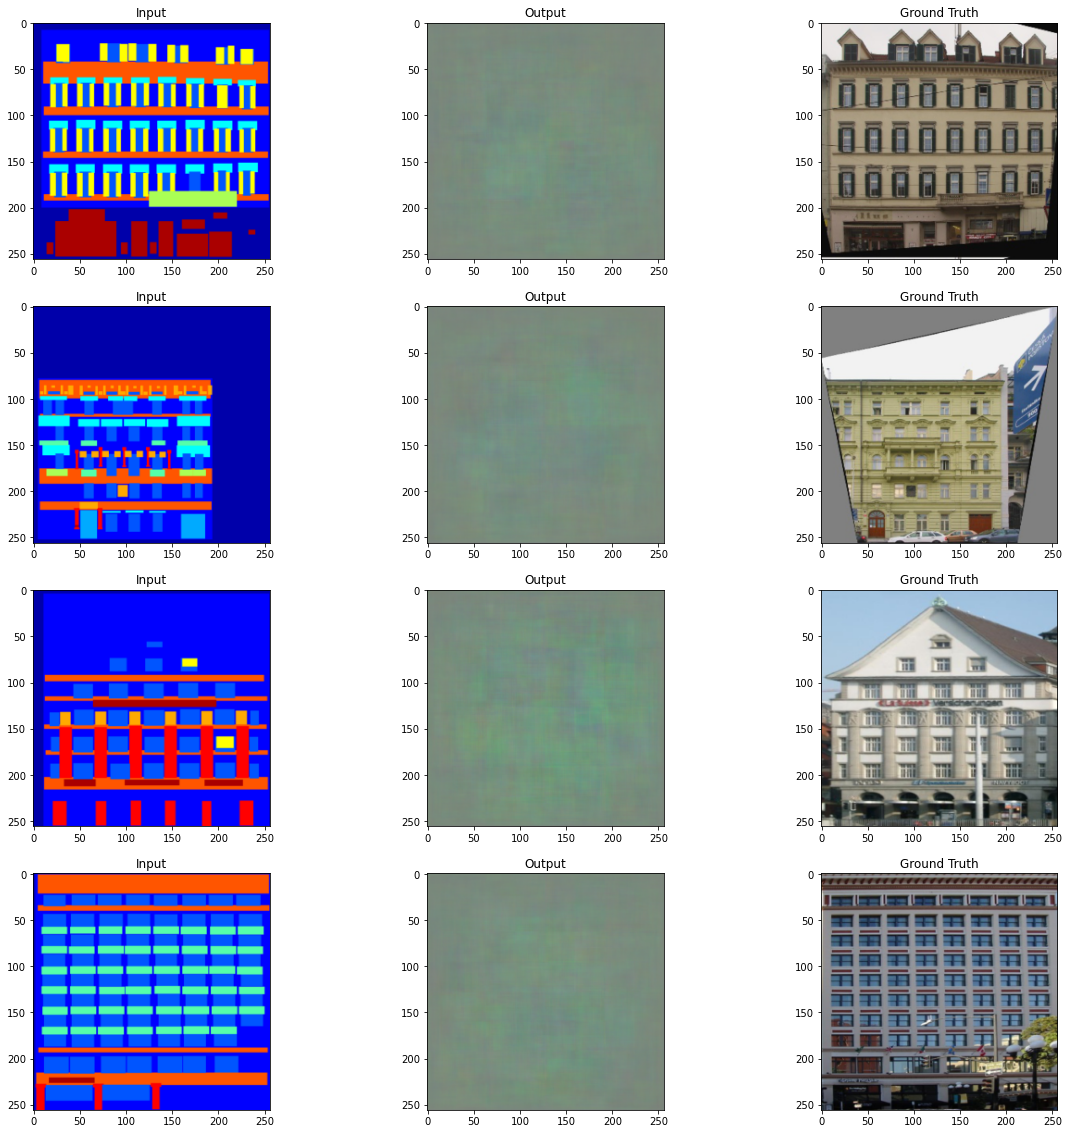

In [221]:
fig,axs = plt.subplots(4,3,figsize=(20,20))
for i,(map,img,fake) in enumerate(zip(infer_maps_conv,infer_images_conv,infer_fakes_conv)):
    # print(i)
    axs[i,0].imshow(map)
    axs[i,0].set_title("Input")
    axs[i,1].imshow(fake)
    axs[i,1].set_title("Output")
    axs[i,2].imshow(img)
    axs[i,2].set_title("Ground Truth")
fig.savefig("op.png")    
    